<a href="https://colab.research.google.com/github/Bokyoung-00/machine_learning_education/blob/master/re_kaggle_house_price_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### (1) 주요 패키지 불러오기
- 이제 주요 패키지를 불러온다.

In [189]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict

### (2) 데이터 불러오기

In [190]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [191]:
# 구글 인증 라이브러리
from google.colab import auth

# 빅쿼리 관련 라이브러리
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

- 훈련 데이터를 불러온다.

In [227]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd
import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn # ignore annoying warning from sklearn and seaborn

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))  
#limiting floats out put to 3 decimal points

project_id = 'eminent-prism-286912'
client = bigquery.Client(project=project_id)

df_train = client.query('''
  SELECT 
      * 
  FROM `eminent-prism-286912.house_price.train`
  ''').to_dataframe()

df_train.shape

(1460, 81)

- 테스트 데이터 불러온다

In [228]:
df_test = client.query('''
  SELECT 
      * 
  FROM `eminent-prism-286912.house_price.test`
  ''').to_dataframe()

df_test.shape

(1459, 80)

In [229]:
pd.options.display.max_columns = None 
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,my1stFlrSF,my2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,my3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [230]:
# ID 를 드럽하는 과정

train_ID = df_train['Id']
test_ID = df_test['Id']

# 이제 ID drop
df_train.drop("Id", axis=1, inplace = True)
df_test.drop("Id", axis=1, inplace = True)


### 데이터 시각화

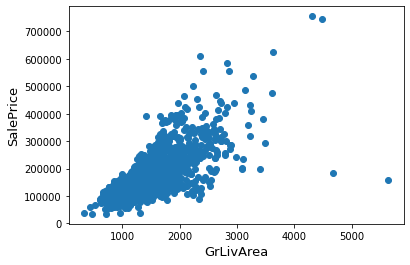

In [196]:

fig, ax= plt.subplots()
ax.scatter(x= df_train['GrLivArea'], y=df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### 타깃 변수


 mu = 180921.20 and sigma = 79415.29



Text(0.5, 1.0, 'SalePrice distribution')

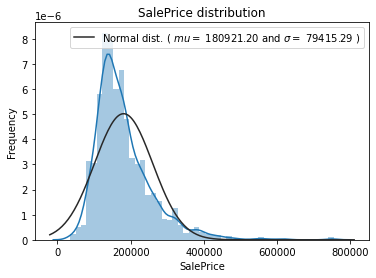

In [197]:
  sns.distplot(df_train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_train['SalePrice'])
print ('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# plot the distribution

plt.legend(['Normal dist. ($\ mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

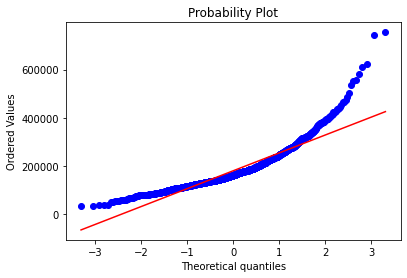

In [198]:
# QQ-plot 
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Log- Transformation of the target variable


 mu = 12.02 and sigma= 0.40



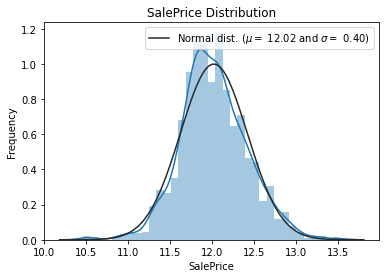

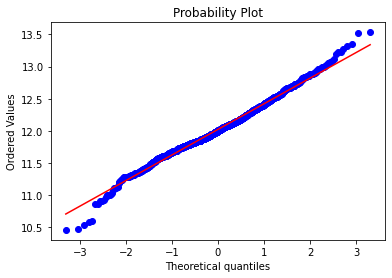

In [231]:
df_train['SalePrice']=np.log1p(df_train['SalePrice'])

sns.distplot(df_train['SalePrice'], fit=norm)

(mu, sigma) = norm.fit(df_train['SalePrice'])
print('\n mu = {:.2f} and sigma= {:.2f}\n'.format(mu, sigma))

#plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc='best')
plt.ylabel('Frequency')
plt.title("SalePrice Distribution")

#QQ-plot
fig = plt.figure()
res= stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Features engineering

In [233]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


### (3) 결측 데이터 확인

In [234]:
# data set의 Percent 구하는 함수를 짜보자. 
def check_fill_na(data):
  new_df = data.copy()
  new_df_na = (new_df.isnull().sum() / len(new_df)) * 100
  new_df_na.sort_values(ascending=False).reset_index(drop=True)
  new_df_na = new_df_na.drop(new_df_na[new_df_na == 0].index).sort_values(ascending=False)
  return new_df_na

check_fill_na(all_data)

PoolQC         99.657
MiscFeature    96.403
Alley          93.217
Fence          80.439
FireplaceQu    48.647
LotFrontage    16.650
GarageFinish    5.447
GarageYrBlt     5.447
GarageQual      5.447
GarageCond      5.447
GarageType      5.379
BsmtExposure    2.809
BsmtCond        2.809
BsmtQual        2.775
BsmtFinType2    2.741
BsmtFinType1    2.706
MasVnrType      0.822
MasVnrArea      0.788
MSZoning        0.137
BsmtFullBath    0.069
BsmtHalfBath    0.069
Utilities       0.069
Functional      0.069
Exterior2nd     0.034
Exterior1st     0.034
SaleType        0.034
BsmtFinSF1      0.034
BsmtFinSF2      0.034
BsmtUnfSF       0.034
Electrical      0.034
KitchenQual     0.034
GarageCars      0.034
GarageArea      0.034
TotalBsmtSF     0.034
dtype: float64

### (4) 주요 함수 정의
- 수치형과 범주형 데이터 결측치의 보간에 관한 함수를 정의한다. 

In [202]:
def fill_missing(df, cols, val):
    """ val 입력값을 넣는다. """
    for col in cols:
        df[col] = df[col].fillna(val)

def fill_missing_with_mode(df, cols):
    """ 최대 빈도수를 넣는다. """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
def addlogs(res, cols):
    """ 로그 변환 """
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res

Transforming categorical values into str

In [235]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### (5) 전체 면적 데이터 추가
- 가정의 전체 면적을 더해서 추가 변수를 만든다.

In [236]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['my1stFlrSF'] + df_train['my2ndFlrSF']

- 전체 수치형 데이터에 `log transformation`을 해준다.

In [237]:
loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
            'TotalBsmtSF','my1stFlrSF','my2ndFlrSF','LowQualFinSF','GrLivArea',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
            'EnclosedPorch','my3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

df_train = addlogs(df_train, loglist)

### (7) 결측치 데이터 보간
- 결측치 데이터를 보간한다. 

In [238]:
# 우선, 결측치가 있는 것 중, 범주형 데이터는 "None"으로 확인
fill_missing(df_train, ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                       "MasVnrType", "MSSubClass"], "None") 

# 수치형 데이터는 0으로 보간
fill_missing(df_train, ["GarageYrBlt", "GarageArea", "GarageCars",
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                       "MasVnrArea"], 0)
# 그 중, 일부는 빈도수로 채워 넣는다.  
fill_missing_with_mode(df_train, ["MSZoning", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"])
fill_missing(df_train, ["Functional"],"Typ")

### (9) 이상치 제거
- 적은 데이터에서 상위 또는 하위 이상치가 발생하는 것은 좋지 않다. 따라서, 해당 관측치는 제거한다. 

In [239]:
df_train.drop(df_train[(df_train['OverallQual']<5) & (df_train['SalePrice']>200000)].index, inplace=True)
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [240]:
all_data=pd.get_dummies(all_data)
print(all_data.shape)

(2919, 326)


In [242]:
train= all_data[:ntrain]
test=all_data[ntrain:]

### (11) 범주형 데이터 다루기
- 이제 범주형 데이터를 원핫 인코딩으로 변환한다. 
- 원핫 인코딩으로 변환하는 이유는, 알고리즘은 수치형으로 되어 있기 때문에 그렇다. 

In [241]:

def fix_missing_cols(in_train, in_test):
    missing_cols = set(in_train.columns) - set(in_test.columns)
    # 테스트 데이터와 훈련 데이터의 컬럼을 동일하게 하는 코드는 작성한다. 
    for c in missing_cols:
        in_test[c] = 0
    # 순서를 동일하게 만든다. 
    in_test = in_test[in_train.columns]
    return in_test

def dummy_encode(in_df_train, in_df_test):
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype == 'object'
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test

- 훈련 데이터와 테스트 데이터의 크기가 다르면 예측 시, 에러가 발생한다. 

In [243]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Shape train: (1456, 333), test: (1459, 333)


In [244]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

cross validation stradegy

In [245]:
#Validation function
n_folds = 5

def rmsle_cv(model):
  kf= KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
  return(rmse)

## III. 머신러닝 모형 개발
- 이제 `LightGBM`을 활용하여 머신러닝 모형을 개발한다. 
- 유투브 강의를 보도록 한다. 


### (1) 종속변수 처리
- 종속변수를 `y` 객체로 저장한다. 

In [246]:
y = df_train["SalePrice"]
y.sample(3)

36    10.933
812   12.367
668   11.736
Name: SalePrice, dtype: float64

- 훈련 및 테스트 데이터의 변수를 삭제한다. 

In [247]:
df_train.drop(["SalePrice"], axis=1, inplace=True)
df_test.drop(["SalePrice"], axis=1, inplace=True)

print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

Shape train: (1456, 332), test: (1459, 332)


### (2) 데이터셋 분리
- 데이터셋을 분리한다. 

In [248]:
X_train, X_test, y_train, y_test = train_test_split( df_train, y, test_size=0.2, random_state=42)

### (3) LightGBM 파라미터 정의
- `LightGBM` 파라미터 정의는 다음 메뉴얼을 읽고 적용한다.
- [LightGBM 파라미터 메뉴얼](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [249]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

### (4) 모델 정의
- 이제 모델을 정의한다. 

In [250]:
gbm = lgb.LGBMRegressor(**hyper_params)

### (5) 모델 학습
- 이제 모델을 학습한다. 

In [251]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

[1]	valid_0's auc: 1	valid_0's l2: 0.186476	valid_0's l1: 0.333035
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's auc: 1	valid_0's l2: 0.18507	valid_0's l1: 0.3316
[3]	valid_0's auc: 1	valid_0's l2: 0.183687	valid_0's l1: 0.330186
[4]	valid_0's auc: 1	valid_0's l2: 0.18231	valid_0's l1: 0.328796
[5]	valid_0's auc: 1	valid_0's l2: 0.180947	valid_0's l1: 0.327395
[6]	valid_0's auc: 1	valid_0's l2: 0.179599	valid_0's l1: 0.326012
[7]	valid_0's auc: 1	valid_0's l2: 0.17827	valid_0's l1: 0.324626
[8]	valid_0's auc: 1	valid_0's l2: 0.176941	valid_0's l1: 0.323255
[9]	valid_0's auc: 1	valid_0's l2: 0.175637	valid_0's l1: 0.321908
[10]	valid_0's auc: 1	valid_0's l2: 0.174333	valid_0's l1: 0.320577
[11]	valid_0's auc: 1	valid_0's l2: 0.173029	valid_0's l1: 0.31924
[12]	valid_0's auc: 1	valid_0's l2: 0.171759	valid_0's l1: 0.317927
[13]	valid_0's auc: 1	valid_0's l2: 0.170416	valid_0's l1: 0.316543
[14]	valid_0's auc: 1	valid_0's l2: 0.16909	valid_0's l1: 0.315179


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.005, max_bin=512,
              max_depth=8, metric=['l2', 'auc'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
              n_jobs=-1, num_iterations=100000, num_leaves=128,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=0)

### (6) 모델 평가
- 모델을 평가한다. (RMSE)

In [252]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', round(mean_squared_log_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 0.02951


### (7) 결과 제출
- 이제 결과를 제출한다. 

In [254]:
test_pred = np.expm1(gbm.predict(df_test, num_iteration=gbm.best_iteration_))
df_test["SalePrice"] = test_pred
df_test.to_csv("new.csv", columns=["Id", "SalePrice"], index=False)

ValueError: ignored